In [1]:
# Here we take care of paths.
# Make sure root project directory is named 'VESUVIUS_Challenge' for this to work

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-18:] == 'VESUVIUS_Challenge':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in the root folder of the project
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/VESUVIUS_Challenge/jupyter notebooks
Current path:/Users/gregory/PROJECT_ML/VESUVIUS_Challenge


In [2]:
import torch
import monai
from monai.visualize import matshow3d
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from typing import Tuple, List
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from Data_Modules.Vesuvius_Dataset import Vesuvius_Tile_Datamodule
from lit_models.Vesuvius_Lit_Model import Lit_Model
from pytorch_lightning.callbacks import ModelCheckpoint
import gc
from torch.utils.data import DataLoader, Dataset
from monai.inferers import sliding_window_inference




2023-05-11 13:20:06,418 - Created a temporary directory at /var/folders/wc/60y8v25x3ns_jgsx6clbdb180000gn/T/tmpixsng27h
2023-05-11 13:20:06,419 - Writing /var/folders/wc/60y8v25x3ns_jgsx6clbdb180000gn/T/tmpixsng27h/_remote_module_non_scriptable.py


In [3]:
CHECKPOINT = 'logs/2BCE05_09tver_alpha08_Monai_FlexU3/BCE02_tver_alpha08_SMPB3epoch=30FBETA=0.43val_loss=0.73fbeta_4=0.16recall=0.47precision=0.67.ckpt'
SAMPLE_SUBMISSION = 'kaggle/input/vesuvius-challenge-ink-detection/sample_submission.csv'


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

# change to the line below if not using Apple's M1 or chips
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
PATCH_SIZE = 224
Z_DIM = 16
COMPETITION_DATA_DIR_str =  "kaggle/input/vesuvius-challenge-ink-detection/"

class CFG:
    
    device = DEVICE
    
    THRESHOLD = 0.5
    use_wandb = False
    
    ######### Dataset #########
    
    # stage: 'train' or 'test'
    stage = 'test' 
    
    # location of competition Data
    competition_data_dir = COMPETITION_DATA_DIR_str
    
    # Number of slices in z-dim: 1<z_dim<65
    z_dim = Z_DIM
    
    # fragments to use for training avalaible [1,2,3]
    train_fragment_id=[2,3]
    
    # fragments to use for validation
    val_fragment_id=[1]
    
    test_fragment_ids = ['a','b']
    
    

    
    
    batch_size = 16
    
    # Size of the patch and stride for feeding the model
    patch_size = PATCH_SIZE
    stride = patch_size // 2
    
    
    num_workers = 0
    on_gpu = True
    
    
    ######## Model and Lightning Model paramters ############
    
    # MODEL
    model = monai.networks.nets.FlexibleUNet(in_channels=z_dim,
                                         out_channels=1,
                                         backbone='efficientnet-b3',
                                         pretrained=True,
                                         decoder_channels=( 512, 256, 128, 64, 32),
                                         spatial_dims=2,
                                         norm=('batch', {'eps': 0.001, 'momentum': 0.1}),
                                         # act=('relu', {'inplace': True}),
                                         act=None,
                                         dropout=0.0,
                                         decoder_bias=False,
                                         upsample='deconv',
                                         interp_mode='nearest',
                                         is_pad=False)
   
    
    
    
    checkpoint = None
    save_directory = None
    
    
    accumulate_grad_batches = 192// batch_size  # experiments showed batch_size * accumulate_grad = 192 is optimal
    learning_rate = 0.0001
    eta_min = 1e-8
    t_max = 80
    max_epochs = 120
    weight_decay =  0.0001
    precision =16
    
    # checkpointing
    save_top_k=5
    
    monitor="FBETA"
    mode="max"
    
    
    ####### Augemtnations ###############
    
    # Training Aug
    train_transforms = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(patch_size, patch_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(patch_size * 0.3), max_height=int(patch_size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * z_dim,
            std= [1] * z_dim
        ),
        ToTensorV2(transpose_mask=True),
    ]
    

    
    # Validaiton Aug
    val_transforms = [
        A.Resize(patch_size, patch_size),
        A.Normalize(
            mean= [0] * z_dim,
            std= [1] * z_dim
        ),
        ToTensorV2(transpose_mask=True),
    ]
    
    # Test Aug
    test_transforms = [
        A.Resize(patch_size, patch_size),
        A.Normalize(
            mean=[0] * z_dim,
            std=[1] * z_dim
        ),

        ToTensorV2(transpose_mask=True),
    ]
        
    
    

In [5]:
lit_model = Lit_Model(cfg=CFG)

lit_model = lit_model.load_from_checkpoint(CHECKPOINT, cfg=CFG,).to(CFG.device)

lit_model.eval()

Lit_Model(
  (metrics): ModuleDict(
    (train_metrics): MetricCollection(
      (dice): Dice(),
      prefix=train_
    )
    (val_metrics): MetricCollection(
      (dice): Dice(),
      prefix=val_
    )
  )
  (model): FlexibleUNet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2d(16, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (_conv_stem_padding): ConstantPad2d(padding=(0, 1, 0, 1), value=0.0)
      (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (_blocks): Sequential(
        (0): Sequential(
          (0): MBConvBlock(
            (_expand_conv): Identity()
            (_expand_conv_padding): Identity()
            (_bn0): Identity()
            (_depthwise_conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), groups=40, bias=False)
            (_depthwise_conv_padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
            (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.01, affine=True, track_running

In [6]:
def read_image_sliding(fragment_id):
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.z_dim // 2
    end = mid + CFG.z_dim // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(COMPETITION_DATA_DIR_str + f"test/{fragment_id}/surface_volume/{i:02}.tif", 0)

        

        images.append(image)
    images = np.stack(images, axis=2)
    
    return images

sliding_transform = A.Compose(
                            [
                            A.Normalize(
                                mean=[0] * CFG.z_dim,
                                std=[1] * CFG.z_dim
                            ),

                            ToTensorV2(transpose_mask=True),
                        ]
                        )

In [7]:
from monai.inferers import sliding_window_inference
#224 stride=8
THRESHOLD =0.4
results = []
for fragment_id in CFG.test_fragment_ids[1]:
    
    image = read_image_sliding(fragment_id)
    #test_dataset = CustomDataset(image, CFG, transform=get_transforms(data='valid', cfg=CFG))
    image = sliding_transform(image=image)['image'].unsqueeze(0).to(CFG.device)
    

   
    print(image.shape)
    h, w = image.shape[2], image.shape[3]
    h_mod = h % 512
    w_mod = w % 512
    h -= h_mod
    w -= w_mod
    outputs = sliding_window_inference(
        inputs=image,
        roi_size=(512, 512),  # self.hparams.patch_size,
        sw_batch_size=4,
        predictor=lit_model,
        overlap=0.1,
        mode='gaussian',
        progress=True,   
        )
    
    print(outputs.shape)
    gc.collect()
    torch.cuda.empty_cache()
    
     
    #binary_mask = cv2.imread(COMPETITION_DATA_DIR_str + f"test/{fragment_id}/mask.png", 0)
    #binary_mask = (binary_mask / 255).astype(int)
    #binary_mask = torch.tensor(binary_mask)#.to(DEVICE)
    
    
    
   


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([1, 16, 2727, 6330])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [02:29<00:00,  3.56s/it]


torch.Size([1, 1, 2727, 6330])


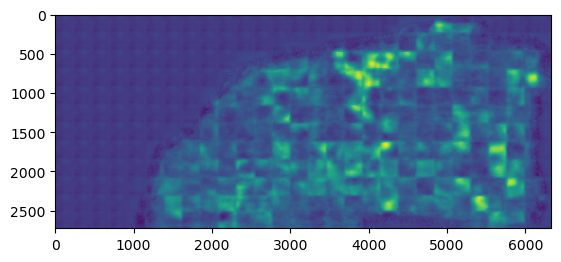

In [14]:
plt.imshow(outputs.squeeze(0).squeeze(0).detach().numpy() )